In [89]:
import misleep
from itertools import groupby
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [90]:
data = misleep.load_mat(r'E:\workplace\EEGProcessing\00_DATA\DA_PFC\DA_4pin_A3_10mA_Zscore.mat')
anno = misleep.load_misleep_anno(r'E:\workplace\EEGProcessing\00_DATA\DA_PFC\A3.txt')
start_end_anno = anno.start_end

# Define a time range for consideration, 
# means every state's duration must be greater than the time
consider_time = 5
consider_channel = 'Zscore'
save_excel_path = r'E:\workplace\EEGProcessing\00_DATA\DA_PFC\A3_transition.xlsx'
save_fig_path = r'E:\workplace\EEGProcessing\00_DATA\DA_PFC\A3_transition.pdf'

In [91]:
# find transition time point
transition_points = []

for idx, state in enumerate(start_end_anno[:-1]):
    next_state = start_end_anno[idx+1]
    # If the previous state and later state have overlap in a second, 
    # make it as a transition time point, 
    # the time point is average of the first state's end and next state's start
    if abs(state[1] - next_state[0]) <= 1:
        # The two states' time must larger than 5 seconds
        if state[1] - state[0] >= consider_time and next_state[1] - next_state[0] > consider_time:
            transition_points.append(
                [f'{state[2]}->{next_state[2]}', round((state[1] + next_state[0])/2, 3)]
            )

In [92]:
_sorted = sorted(transition_points, key=lambda x: x[0])
transition_points_group = [list(each) for _, each in groupby(_sorted, lambda x: x[0])]

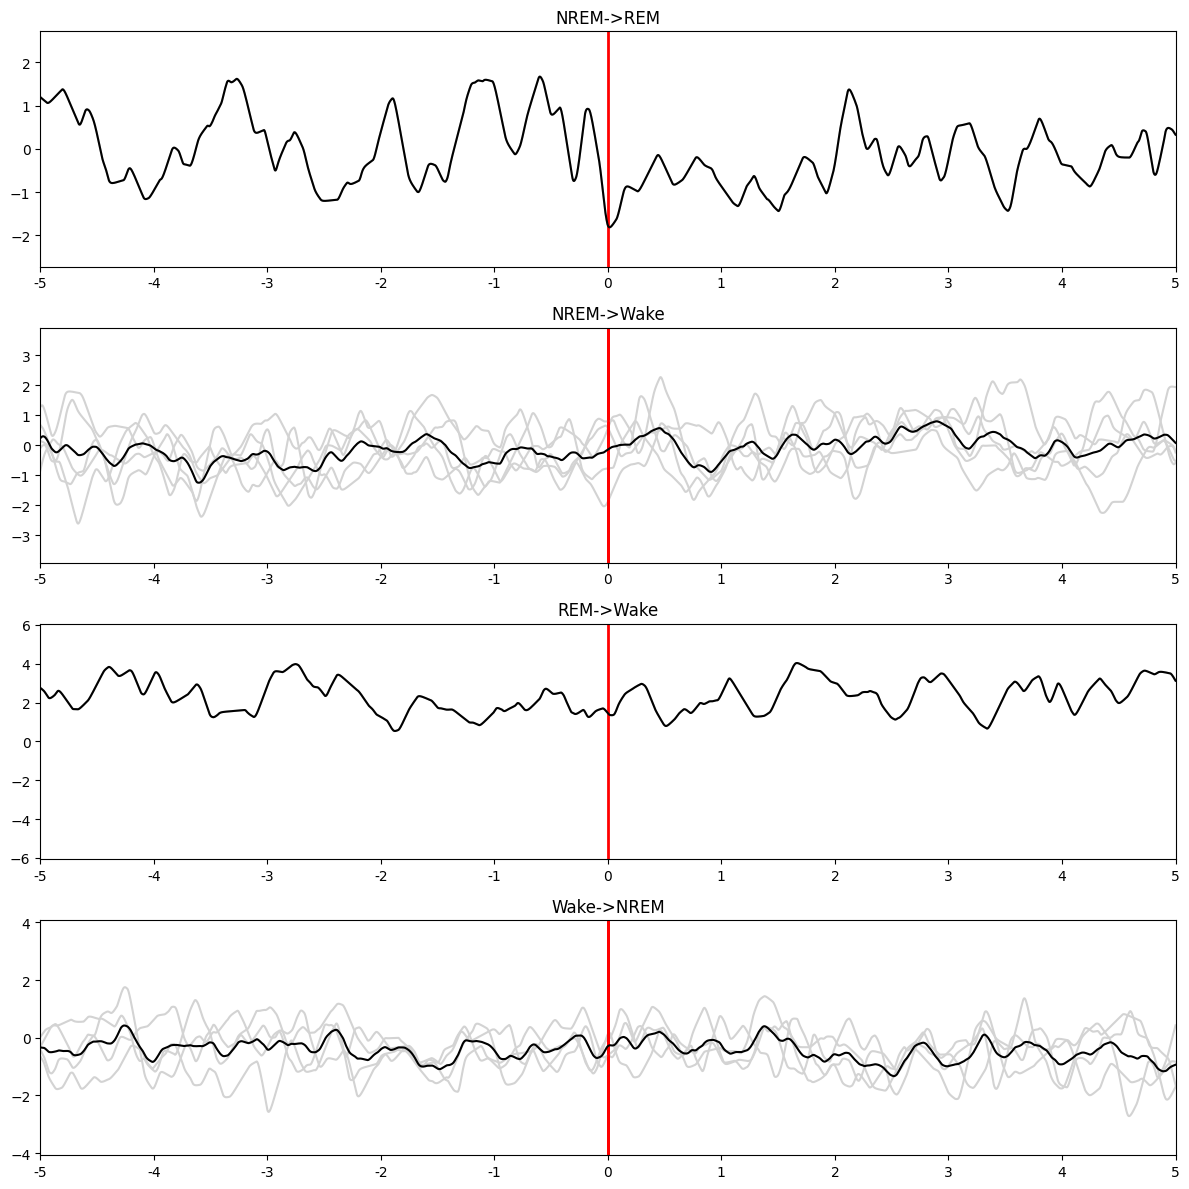

In [93]:
# Get data based on each group of transition time points
channel_midata = data.pick_chs(ch_names=[consider_channel])
channel_data = channel_midata.signals[0]
sf = channel_midata.sf[0]
writer = pd.ExcelWriter(save_excel_path)

signal_figure = plt.figure(figsize=(12, 3*len(transition_points_group)))
signal_ax = signal_figure.subplots(nrows=len(transition_points_group))
signal_figure.set_tight_layout(True)

for idx, group in enumerate(transition_points_group):
    _group_data = []
    _group_name = group[0][0]
    _group_time_points = [each[1] for each in group]
    for transition in _group_time_points:
        # Get data based on each transition time point
        start_time = transition - consider_time
        end_time = transition + consider_time
        _group_data.append(channel_data[int(start_time*sf): int(end_time*sf)])
    # align length of each transition data
    _length = min([len(each) for each in _group_data])
    _group_data = np.array([each[:_length] for each in _group_data])
    for each in _group_data:
        signal_ax[idx].plot(each, color='lightgray')
        signal_ax[idx].axvline(_length/2, color='red', linewidth=2)
        signal_ax[idx].set_xlim(0, _length)
        _max = np.max(np.abs(_group_data))*1.5
        signal_ax[idx].set_ylim(-_max, _max)
        signal_ax[idx].set_title(_group_name)

    # calculate mean line
    _mean_group_data = np.mean(_group_data, axis=0)
    signal_ax[idx].plot(_mean_group_data, color='black')

    signal_ax[idx].xaxis.set_ticks(
        [int(each * sf) for each in range(0, 2*consider_time+1, 1)],
        np.arange(-consider_time, consider_time+1, 1),
    )
        
    _df = pd.DataFrame(data=_group_data.T, columns=_group_time_points)
    _df.to_excel(excel_writer=writer, sheet_name=_group_name, index=False)

signal_figure.savefig(save_fig_path, dpi=300)
writer.close()

signal_figure.show()
